In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from bayesian_pdes.util import bccb
%load_ext line_profiler

In [2]:
l = 1.
dt = 0.01
omega = 1./15.
eta = 0.03
A_0 = 1./30.
# static hotspots
theta = 0.56
Gamma = 0.019
# dynamic hotspots
#theta = 5.6
#Gamma = 0.002
z = 4.

D = l**2 / dt
epsilon = theta*dt
gamma = Gamma / l**2
B_bar = epsilon*D*gamma / omega

A_init = A_0 + B_bar
rho_init = B_bar / A_init


In [3]:
N_spatial = 128
x_sq, y_sq = np.meshgrid(np.arange(0, N_spatial, int(l)), np.arange(0, N_spatial, int(l)), indexing='xy')
x = x_sq.ravel()
y = y_sq.ravel()

In [4]:
lshift = (x + 1) % N_spatial + y*N_spatial
rshift = (x - 1) % N_spatial + y*N_spatial
ushift = x + ((y+1) % N_spatial)*N_spatial
dshift = x + ((y-1) % N_spatial)*N_spatial

In [5]:
def laplacian(vec):
    return (vec[rshift] + vec[lshift] + vec[ushift] + vec[dshift] - 4*vec) / l**2

def grad_x(vec):
    return (vec[lshift] - vec[rshift]) / (2*l)

def grad_y(vec):
    return (vec[ushift] - vec[dshift]) / (2*l)

In [7]:
diag_B = 1 + omega*dt - eta*D*dt / z * -4./l**2
off_diag_B = -eta*D*dt/z * 1./l**2
first_col_B = np.zeros(len(x))
first_col_B[0] = diag_B
first_col_B[[lshift[0], rshift[0], ushift[0], dshift[0]]] = off_diag_B

bccb_shape=(N_spatial,N_spatial)

bccb_eigs_B = bccb.bccb_eigs(first_col_B, bccb_shape, reshape=False)

def solve_B(B_n, A_n, rho_n, return_mats=False):
    rhs_vec = B_n + epsilon*D*dt*rho_n*A_n
    
    bccb_soln = bccb.bccb_solve(first_col_B, rhs_vec, bccb_shape, bccb_eigs_B)
    #bccb_soln = linalg.solve_circulant(first_col_B, rhs_vec)
    
    res = np.real(bccb_soln)
    if return_mats:
        return first_col_B, rhs_vec, res
    return res

In [8]:
def solve_rho(B_n, A_n, rho_n, return_mats=False):
    laplacian_A = laplacian(A_n)
    grad_A_x = grad_x(A_n)
    grad_A_y = grad_y(A_n)
    grad_rho_x = grad_x(rho_n)
    grad_rho_y = grad_y(rho_n)
    f = 2*D*dt / z * (laplacian_A / A_n - (grad_A_x**2 + grad_A_y**2) / A_n**2) + A_n*dt
    C = np.max(f)
    #C = 0
    
    diag = 1 + C - D*dt/z * -4./l**2
    off_diag = -D*dt/z * 1./l**2
    
    first_col = np.zeros(len(A_n))
    first_col[0] = diag
    first_col[[lshift[0], rshift[0], ushift[0], dshift[0]]] = off_diag
    
    rhs_vec = (1 + C - f) * rho_n - 2*D*dt/z * (grad_rho_x*grad_A_x + grad_rho_y*grad_A_y) / A_n + gamma*dt
    
    bccb_sol = bccb.bccb_solve(first_col, rhs_vec, bccb_shape)
    #bccb_sol = linalg.solve_circulant(first_col, rhs_vec)
    res = np.real(bccb_sol)
    
    if return_mats:
        return first_col, rhs_vec, res
    return res

In [17]:
import os
base_dir = 'crime_results_2d'
A_file_pattern = os.path.join(base_dir, 'A_t={}.npy')
rho_file_pattern = os.path.join(base_dir, 'rho_t={}.npy')

n_initial_spots = 20

def solve_forward(times, save_interval=100):
    A = []
    rho = []

    #A_n = A_init*np.ones(len(x)) + np.random.normal(0, 0.01, len(x))
    A_n = A_init*np.ones(len(x))
    for i in xrange(n_initial_spots):
        loc = np.random.randint(0, len(x))
        A_n[loc] = A_n[loc] * 1.1
    rho_n = rho_init*np.ones(len(x))
    
    with open(A_file_pattern.format(0.), 'wb') as f:
        np.save(f, A_n)

    with open(rho_file_pattern.format(0.), 'wb') as f:
        np.save(f, rho_n)
    
    A.append(A_n)
    rho.append(rho_n)
    for ix, t in enumerate(times):
        if ix % 100 == 0: print ix,
        B_next = solve_B(A_n-A_0, A_n, rho_n)
        A_next = B_next + A_0
        
        rho_next = solve_rho(A_n-A_0, A_n, rho_n)

        if np.any(np.isnan(A_next)): 
            print('NaN values encountered in A_n')
            return A, rho
        if np.any(np.isnan(rho_next)):
            print('NaN values encountered in rho_n')
            return A, rho
        
        A_n = A_next
        rho_n = rho_next
        
        if (ix + 1) % save_interval == 0:
            #with open(A_file_pattern.format(t), 'wb') as f:
            #    np.save(f, A_n)

            #with open(rho_file_pattern.format(t), 'wb') as f:
            #    np.save(f, rho_n)
            A.append(A_n)
            rho.append(rho_n)
    
    return A, rho

In [27]:
%%time
Tend = 500
np.random.seed(123)
A, rho = solve_forward(np.arange(dt, Tend+dt, dt))

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 18

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in multiply
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in square
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in multiply


In [112]:
#np.save('crime_results_2d/A_random_seed.npy', A[:-1])
#np.save('crime_results_2d/rho_random_seed.npy', rho[:-1])

In [35]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

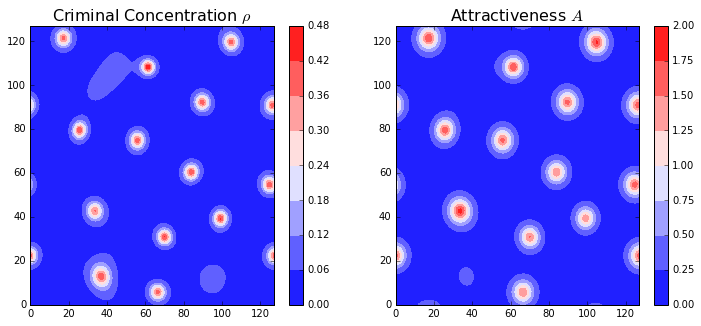

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Criminal Concentration $\\rho$', fontsize=16)
plt.contourf(x_sq, y_sq, rho[-10].reshape(x_sq.shape), cmap='bwr')
plt.colorbar()

plt.subplot(122)
plt.title('Attractiveness $A$', fontsize=16)
plt.contourf(x_sq, y_sq, A[-10].reshape(x_sq.shape), cmap='bwr')
plt.colorbar()

plt.savefig('crime_results_2d.pdf', transparent=True, bbox_inches=0)

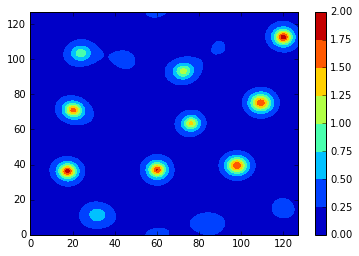

In [12]:
plt.contourf(x_sq, y_sq, A[-1].reshape(x_sq.shape))
plt.colorbar()

In [12]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
from matplotlib import animation
animation.Animation._repr_html_ = anim_to_html

In [13]:
# First set up the figure, the axis, and the plot element we want to animate
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xlim(0, N_spatial)
ax.set_ylim(0,1)
fig = plt.gcf()
A_line, = ax.plot([], [], label='A')
rho_line, = ax.plot([], [], label='rho')
skip = 100
plt.legend()
# initialization function: plot the background of each frame
def init():
    return []

# animation function.  This is called sequentially
def animate(i):
    A_line.set_data(x, A[skip*i])
    rho_line.set_data(x, rho[skip*i])
    return A_line, rho_line

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(A) / skip, interval=20, blit=True)
plt.close()
anim